In [1]:
# ==========================
# Install & import packages
# ==========================
!pip install requests pandas numpy scikit-learn seaborn matplotlib
!pip install fuzzywuzzy[speedup]

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

from fuzzywuzzy import process

from google.colab import drive
from google.colab import userdata

sns.set(style="whitegrid")

# ==========================
# API Key
# ==========================
API_KEY = userdata.get('TMDB_Key')  # or hardcode your key here

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.1 MB/s eta 0:00:00


Data collection

In [2]:
# ==========================
# Get TV shows data from TMDB
# ==========================
def get_tv_shows(api_key, pages=5, endpoint="tv/popular"):
    BASE_URL = 'https://api.themoviedb.org/3'
    dataset = []

    for page in range(1, pages+1):
        url = f"{BASE_URL}/{endpoint}?api_key={api_key}&language=en-US&page={page}"
        response = requests.get(url)
        if response.status_code != 200:
            print("Error:", response.json())
            continue
        shows = response.json()['results']

        for show in shows:
            show_id = show['id']
            details_url = f"{BASE_URL}/tv/{show_id}?api_key={api_key}&language=en-US"
            details = requests.get(details_url).json()

            genres = [g['name'] for g in details.get('genres', [])]
            episode_time = details.get('episode_run_time', [0])[0] if details.get('episode_run_time') else 0

            dataset.append({
                'name': show.get('name'),
                'rating': show.get('vote_average'),
                'episode_run_time': episode_time,
                'genres': genres,
                'popularity': show.get('popularity')
            })

            time.sleep(0.2)  # avoid hitting rate limits

    return pd.DataFrame(dataset)

# Fetch data
df = get_tv_shows(API_KEY, pages=5)
print(df.head())

                                     name  rating  episode_run_time  \
0                              Squid Game   7.900                 0   
1  The Late Late Show with Craig Ferguson   6.785                60   
2      The Late Show with Stephen Colbert   6.362                 0   
3                          The Daily Show   6.367                30   
4                           Among Friends   3.200                12   

                                 genres  popularity  
0  [Action & Adventure, Mystery, Drama]   2111.7522  
1                        [Comedy, Talk]    805.4902  
2                        [Comedy, Talk]    708.1901  
3                        [News, Comedy]    659.9982  
4                       [Drama, Family]    633.2599  


Data preparation & feature engineering

In [3]:
# ==========================
# Handle missing genres & one-hot encoding
# ==========================
df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else [])

all_genres = set(g for sublist in df['genres'] for g in sublist)
for genre in all_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

# ==========================
# Prepare features for clustering
# ==========================
X = df[['rating', 'episode_run_time', 'popularity'] + list(all_genres)]
X.fillna(X.mean(), inplace=True)

# ==========================
# Scale data
# ==========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/tmp/ipython-input-3-4145276992.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


EDA & Elbow method

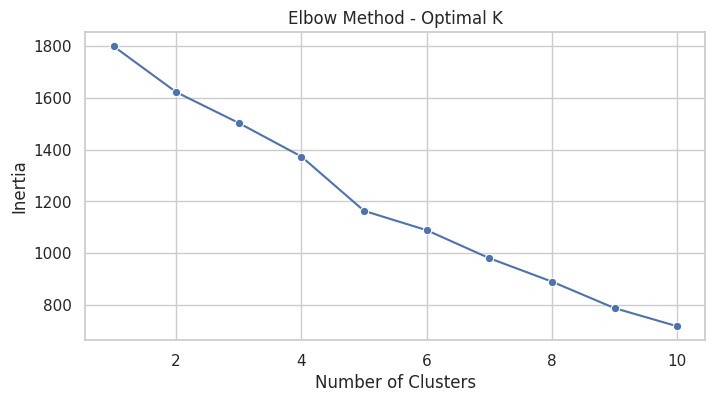

In [4]:
# ==========================
# Elbow Method to find optimal K
# ==========================
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
sns.lineplot(x=K_range, y=inertia, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Clustering

In [5]:
# ==========================
# K-Means
# ==========================
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# ==========================
# Hierarchical Clustering
# ==========================
agg = AgglomerativeClustering(n_clusters=4)
df['AggloCluster'] = agg.fit_predict(X_scaled)

# ==========================
# DBSCAN
# ==========================
dbscan = DBSCAN(eps=2, min_samples=5)
df['DBSCANCluster'] = dbscan.fit_predict(X_scaled)

PCA Visualization

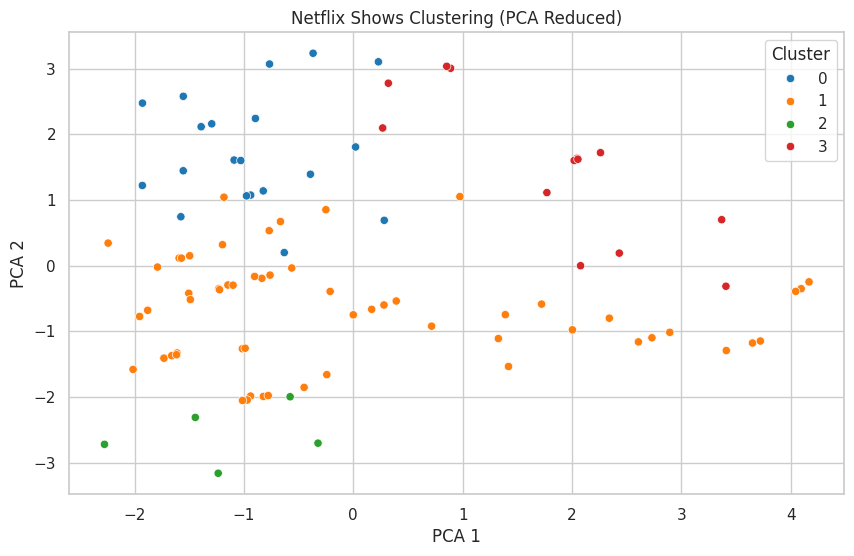

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='tab10')
plt.title('Netflix Shows Clustering (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Cluster analysis & EDA plots

           rating  episode_run_time  popularity
Cluster                                        
0        7.136571         31.428571  400.401948
1        6.357361         30.852459  311.084820
2        6.150200         28.600000  434.324080
3        7.996692         16.615385  247.956562
         Documentary     Drama   Reality  Animation      Talk  \
Cluster                                                         
0           0.000000  0.952381  0.047619   0.000000  0.000000   
1           0.032787  0.081967  0.213115   0.245902  0.245902   
2           0.000000  0.000000  0.000000   0.000000  0.800000   
3           0.000000  0.384615  0.000000   0.692308  0.000000   

         Action & Adventure     Crime  Sci-Fi & Fantasy  News   Mystery  \
Cluster                                                                   
0                  0.238095  0.428571               0.0   0.0  0.095238   
1                  0.049180  0.000000               0.0   0.0  0.032787   
2                  0.

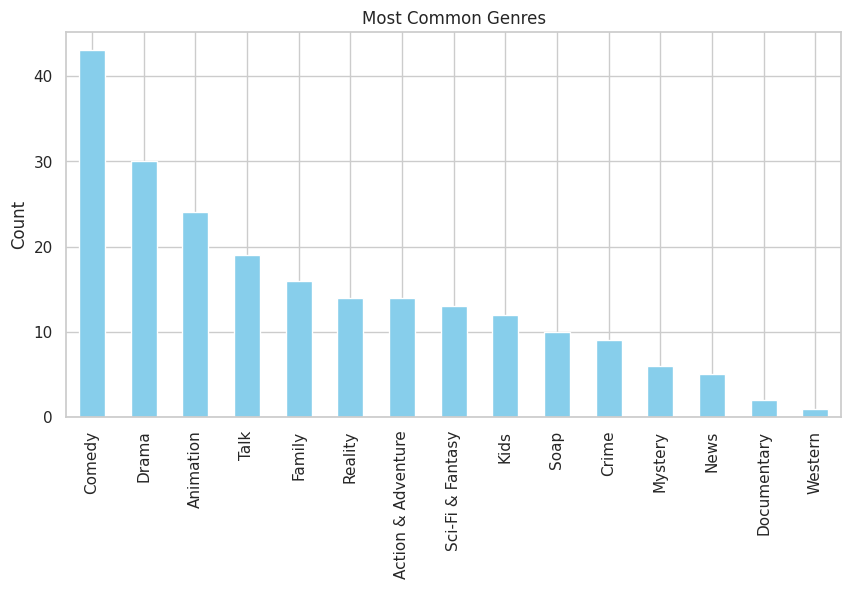

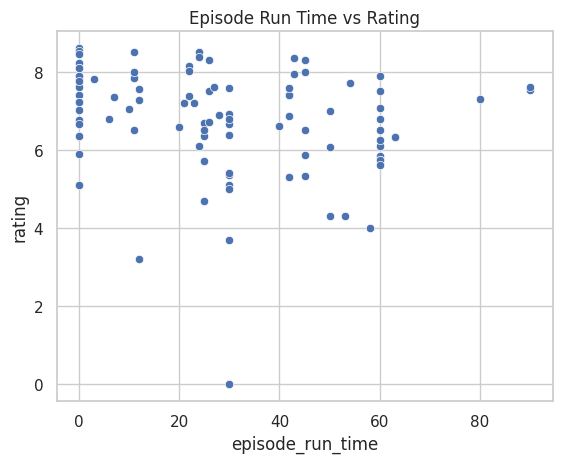

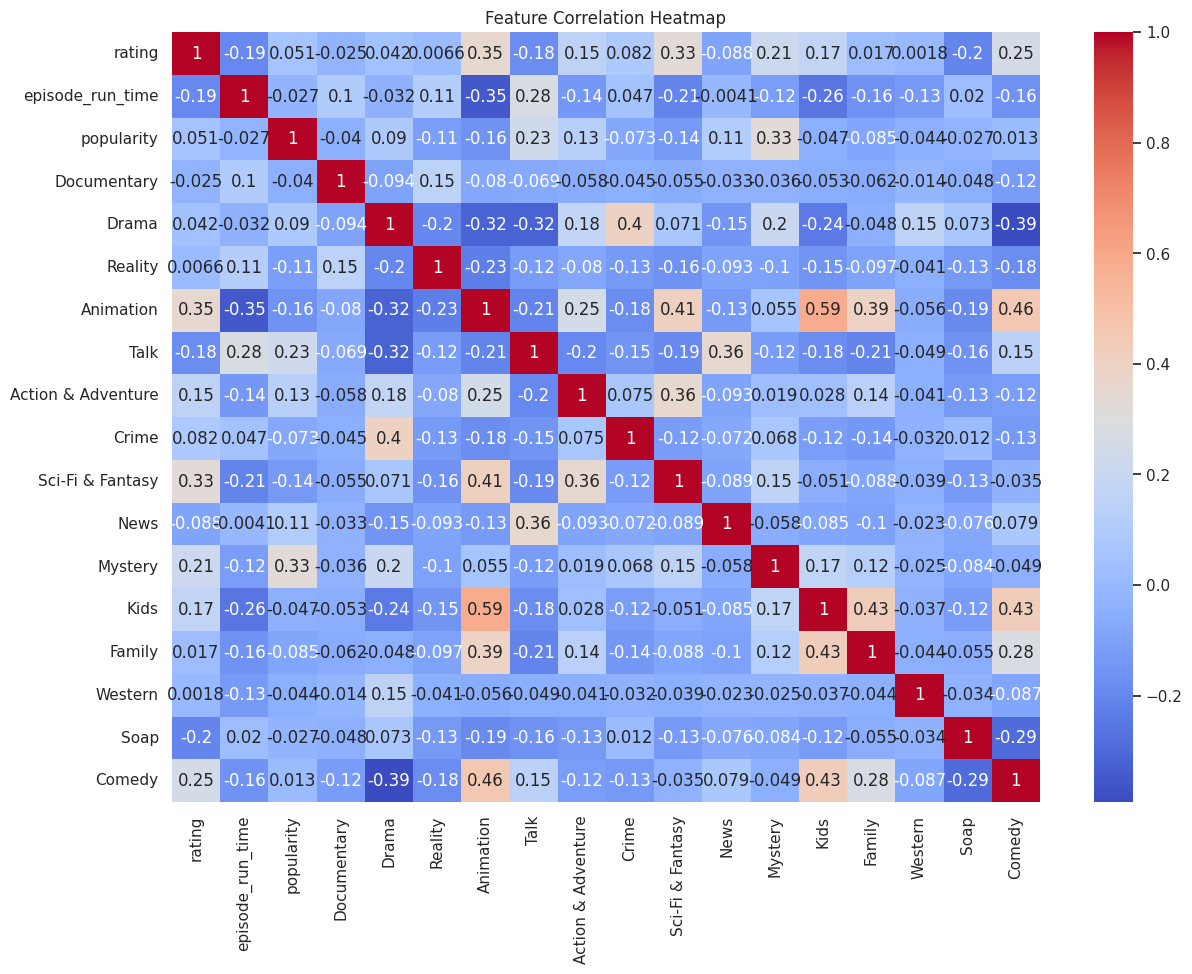

In [7]:
# ==========================
# 🔍 Cluster summaries
# ==========================
print(df.groupby('Cluster')[['rating', 'episode_run_time', 'popularity']].mean())

# ==========================
# 🔍 Dominant genres by cluster
# ==========================
print(df.groupby('Cluster')[list(all_genres)].mean())

# ==========================
# 🔍 Popular genres
# ==========================
all_genres_flat = list(itertools.chain(*df['genres']))
pd.Series(all_genres_flat).value_counts().plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Most Common Genres")
plt.ylabel("Count")
plt.show()

# ==========================
# 🔍 Runtime vs Rating
# ==========================
sns.scatterplot(x='episode_run_time', y='rating', data=df)
plt.title("Episode Run Time vs Rating")
plt.show()

# ==========================
# 🔍 Correlation heatmap
# ==========================
corr_features = ['rating', 'episode_run_time', 'popularity'] + list(all_genres)
plt.figure(figsize=(14,10))
sns.heatmap(df[corr_features].corr(), cmap='coolwarm', annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

Recommendations using Fuzzy input

In [8]:
def find_best_matches(input_names, choices, cutoff=90):
    matches = []
    for name in input_names:
        best_match, score = process.extractOne(name, choices)
        if score >= cutoff:
            matches.append(best_match)
    return matches

def recommend_custom_input_fuzzy(n=5):
    user_input = input("Enter 1, 2 or 3 shows you like (comma-separated): ")
    liked_show_names = [name.strip() for name in user_input.split(",")]

    choices = df['name'].unique()
    best_matches = find_best_matches(liked_show_names, choices)

    if not best_matches:
        print("No close matches found.")
        print("Some shows you can pick from:", df['name'].sample(5).to_list())
        return

    cluster_id = df[df['name'].isin(best_matches)]['Cluster'].mode().iloc[0]
    recs = df[(df['Cluster'] == cluster_id) & (~df['name'].isin(best_matches))]

    print(f"Found closest matches: {best_matches}")
    print(f"Recommendations from cluster {cluster_id}:")
    print(recs[['name', 'rating', 'episode_run_time', 'genres']].sample(min(n, len(recs))))

recommend_custom_input_fuzzy()

Enter 1, 2 or 3 shows you like (comma-separated): brooklyn 99, big bang theory, friends
Found closest matches: ['Among Friends']
Recommendations from cluster 1:
                              name  rating  episode_run_time  \
68                       Jeopardy!   6.906                30   
35                         Horizon   7.516                60   
91  Des squelettes dans le placard   0.000                30   
45           Good Mythical Morning   7.037                10   
15                  The Loud House   7.833                11   

                                        genres  
68                           [Reality, Family]  
35                               [Documentary]  
91                                          []  
45                                    [Comedy]  
15  [Animation, Comedy, Family, Kids, Mystery]  


Save as CSV

In [9]:
# ==========================
# Export for Tableau
# ==========================
drive.mount('/content/drive')
df.to_csv('/content/drive/MyDrive/NetflixShowClustering/netflix_shows_clustered.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
